<a href="https://colab.research.google.com/github/rehmat3121/House-Price-predictions/blob/main/House_Price_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


import joblib
import json
import warnings
warnings.filterwarnings("ignore")


# Visual settings
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

2. LOAD DATA

In [2]:
raw = pd.read_csv("/content/House Price India.csv")
print("Dataset loaded.")
print(raw.head())


# Rename target to something easier
raw = raw.rename(columns={"Price": "SalePrice"})

Dataset loaded.
           id   Date  number of bedrooms  number of bathrooms  living area  \
0  6762810145  42491                   5                 2.50         3650   
1  6762810635  42491                   4                 2.50         2920   
2  6762810998  42491                   5                 2.75         2910   
3  6762812605  42491                   4                 2.50         3310   
4  6762812919  42491                   3                 2.00         2710   

   lot area  number of floors  waterfront present  number of views  \
0      9050               2.0                   0                4   
1      4000               1.5                   0                0   
2      9480               1.5                   0                0   
3     42998               2.0                   0                0   
4      4500               1.5                   0                0   

   condition of the house  ...  Built Year  Renovation Year  Postal Code  \
0                 

3. DATA SUMMARY + MISSING VALUES

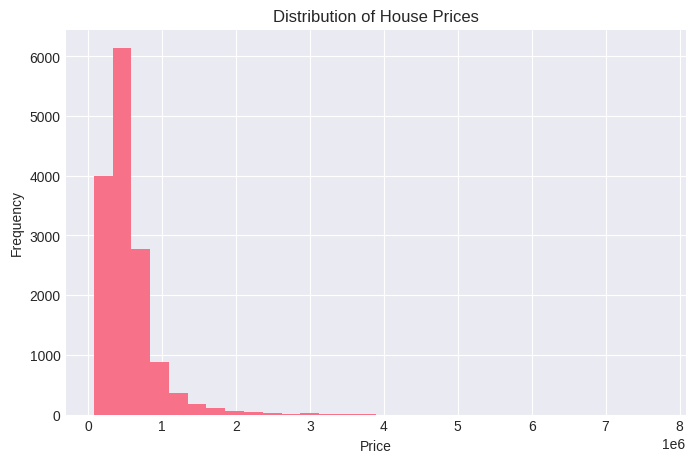


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14620 entries, 0 to 14619
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     14620 non-null  int64  
 1   Date                                   14620 non-null  int64  
 2   number of bedrooms                     14620 non-null  int64  
 3   number of bathrooms                    14620 non-null  float64
 4   living area                            14620 non-null  int64  
 5   lot area                               14620 non-null  int64  
 6   number of floors                       14620 non-null  float64
 7   waterfront present                     14620 non-null  int64  
 8   number of views                        14620 non-null  int64  
 9   condition of the house                 14620 non-null  int64  
 10  grade of the house                     14620 non-null  in

In [18]:
plt.figure(figsize=(8,5))
plt.hist(raw['SalePrice'], bins=30)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

print("\nBasic Info:")
print(raw.info())


missing_stats = raw.isna().sum().to_frame("Missing")
missing_stats["Percent"] = (missing_stats["Missing"] / len(raw)) * 100
print("\nMissing Value Summary:\n", missing_stats)

4. SIMPLE BASELINES

In [4]:
def evaluate(y_true, y_pred):
  return {
"RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
"MAE": mean_absolute_error(y_true, y_pred),
"R2": r2_score(y_true, y_pred),
"MAPE": mean_absolute_percentage_error(y_true, y_pred)
}


# Mean baseline
mean_val = raw["SalePrice"].mean()
mean_pred = np.full(len(raw), mean_val)
print("\nBaseline (Mean):", evaluate(raw["SalePrice"], mean_pred))


# Median baseline
med_val = raw["SalePrice"].median()
med_pred = np.full(len(raw), med_val)
print("Baseline (Median):", evaluate(raw["SalePrice"], med_pred))


Baseline (Mean): {'RMSE': np.float64(367519.8110821553), 'MAE': 233142.58463780108, 'R2': 0.0, 'MAPE': 0.5349397863281752}
Baseline (Median): {'RMSE': np.float64(378126.633543771), 'MAE': 221062.11354309166, 'R2': -0.058554023383986964, 'MAPE': 0.4255272361877399}


5. TRAIN/TEST SPLIT

In [22]:
# Select numeric predictors automatically
num_feats = raw.select_dtypes(include=[np.number]).drop(columns=["SalePrice"]).columns


X = raw[num_feats]
y = raw["SalePrice"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


print(f"Training size: {X_train.shape}, Testing size: {X_test.shape}")

Training size: (11696, 22), Testing size: (2924, 22)


6. MULTICOLLINEARITY CHECK

In [6]:
def compute_vif(df):
  vif_result = []
  for i in range(df.shape[1]):
     vif_result.append(variance_inflation_factor(df.values, i))
  return pd.DataFrame({"Feature": df.columns, "VIF": vif_result})


print("\nVIF Table:\n", compute_vif(X_train))


VIF Table:
                                   Feature           VIF
0                                      id  4.908959e+07
1                                    Date  1.005565e+00
2                      number of bedrooms  1.611251e+00
3                     number of bathrooms  3.284439e+00
4                             living area           inf
5                                lot area  1.975949e+00
6                        number of floors  2.009232e+00
7                      waterfront present  1.172953e+00
8                         number of views  1.402278e+00
9                  condition of the house  1.266937e+00
10                     grade of the house  3.456535e+00
11  Area of the house(excluding basement)           inf
12                   Area of the basement           inf
13                             Built Year  2.397709e+00
14                        Renovation Year  1.155662e+00
15                            Postal Code  1.167313e+00
16                              Lat

7. MODEL TRAINING

In [7]:
models = {
"Linear": LinearRegression(),
"Ridge": Ridge(alpha=1.0),
"Lasso": Lasso(alpha=0.01),
"ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5)
}


model_scores = {}


for label, mdl in models.items():
  mdl.fit(X_train, y_train)
  preds = mdl.predict(X_test)
  model_scores[label] = evaluate(y_test, preds)
  print(f"\n{label} Model:", model_scores[label])


Linear Model: {'RMSE': np.float64(216630.2833939172), 'MAE': 105531.6141670321, 'R2': 0.7318394663562908, 'MAPE': 0.19524265710765665}

Ridge Model: {'RMSE': np.float64(216733.3334063742), 'MAE': 105545.43841405574, 'R2': 0.7315842802524006, 'MAPE': 0.19520776450015004}

Lasso Model: {'RMSE': np.float64(216630.31580333205), 'MAE': 105531.60825283191, 'R2': 0.731839386118879, 'MAPE': 0.19524261575687646}

ElasticNet Model: {'RMSE': np.float64(220989.41366149206), 'MAE': 106023.73342744172, 'R2': 0.7209387953030265, 'MAPE': 0.19417890310420136}


8. K-FOLD CROSS VALIDATION

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=12)


cv_results = {}
for label, mdl in models.items():
  cv_rmse = np.sqrt(-cross_val_score(mdl, X, y, scoring="neg_mean_squared_error", cv=kf)).mean()
  cv_results[label] = cv_rmse


print("\nCross-Validation RMSE:")
print(cv_results)


Cross-Validation RMSE:
{'Linear': np.float64(186684.13533388273), 'Ridge': np.float64(186683.3866140886), 'Lasso': np.float64(186684.13596667815), 'ElasticNet': np.float64(187630.0902280157)}


9. CHAMPION MODEL SELECTION

In [9]:
champion = min(cv_results, key=cv_results.get)
print(f"\nChampion Model Selected: {champion}")


final_model = models[champion]
final_model.fit(X, y)


Champion Model Selected: Ridge


Ridge()

10. SAVE ARTIFACTS

In [10]:
joblib.dump(final_model, "champion_model.joblib")
print("Model saved: champion_model.joblib")


test_predictions = final_model.predict(X_test)
pred_df = pd.DataFrame({"Actual": y_test, "Predicted": test_predictions})
pred_df.to_csv("houseprice_predictions_test.csv", index=False)
print("Predictions saved: houseprice_predictions_test.csv")


metrics_to_save = evaluate(y_test, test_predictions)
with open("test_metrics.json", "w") as f:
   json.dump(metrics_to_save, f, indent=4)
print("Metrics saved: test_metrics.json")

Model saved: champion_model.joblib
Predictions saved: houseprice_predictions_test.csv
Metrics saved: test_metrics.json


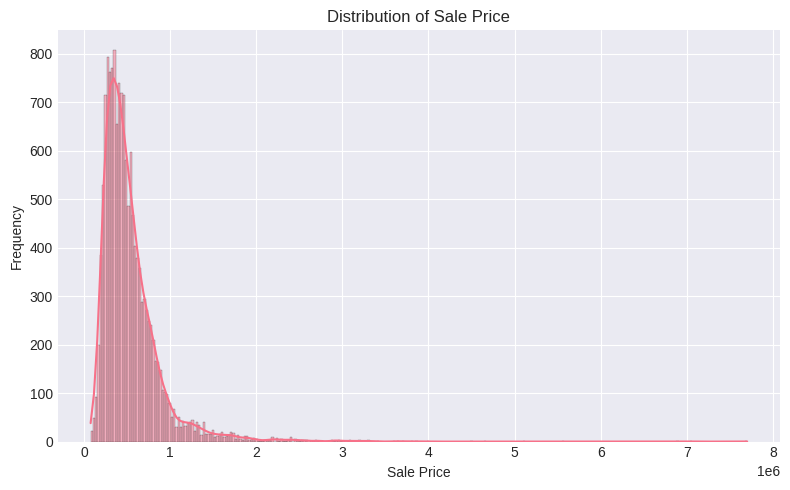

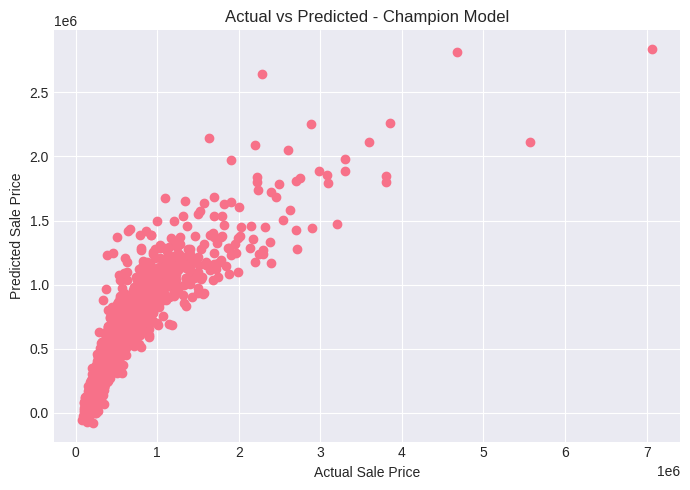

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(raw['SalePrice'], kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# 2. Actual vs Predicted Plot (Champion Model)
plt.figure(figsize=(7,5))
plt.scatter(y_test, test_predictions)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted - Champion Model')
plt.tight_layout()
plt.show()